In [1]:
%%capture
%run common.ipy
from fns import ColumnRename, MatrixToDataFrame

![](pipeline.png)

![](dataflow.png)

# Load Data

In [2]:
df = pd.read_csv('data/titanic.csv')
y = df.Survived
X = df.drop(['Survived'], axis=1)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
X.head(3)

,Index,Passenger Id,P class,Name,Sex,Age,Sib Sp,Parch,Ticket,Fare,Cabin,Embarked
0,0,1,three,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,1,2,one,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,2,3,three,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S


In [3]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Index         891 non-null    int64  
 1   Passenger Id  891 non-null    int64  
 2   P class       889 non-null    object 
 3   Name          891 non-null    object 
 4   Sex           888 non-null    object 
 5   Age           714 non-null    float64
 6   Sib Sp        891 non-null    int64  
 7   Parch         891 non-null    int64  
 8   Ticket        891 non-null    object 
 9   Fare          888 non-null    float64
 10  Cabin         204 non-null    object 
 11  Embarked      889 non-null    object 
dtypes: float64(2), int64(4), object(6)
memory usage: 83.7+ KB


In [4]:
X.isna().sum()

# Install Nightly `sklearn`

- https://scikit-learn.org/stable/developers/advanced_installation.html
- `pip install --pre --extra-index https://pypi.anaconda.org/scipy-wheels-nightly/simple scikit-learn --upgrade`

In [5]:
!pip list | grep scikit

scikit-learn         1.1.dev0


# Notes

- Every step in a Pipeline produces a new DataFrame or Matrix
- Every step in a Column Transformer is adding a new column to that new DataFrame or Matrix produced by the Pipeline

# Column Transformers

In [6]:
imputer = ColumnTransformer([
    ('drop_features', 'drop', ['index', 'passenger_id', 'name', 'ticket', 'cabin']),
    ('impute_mean', SimpleImputer(strategy='mean'), ['age', 'sib_sp', 'parch', 'fare']),
    ('impute_mode', SimpleImputer(strategy='most_frequent'), ['p_class', 'sex', 'embarked']),
], remainder='passthrough', verbose_feature_names_out=False)

In [7]:
encoder = ColumnTransformer([
    ('ord_enc', OrdinalEncoder(categories=[['one', 'two', 'three']], handle_unknown='use_encoded_value', unknown_value=3), ['p_class']),
    ('one_hot', OneHotEncoder(handle_unknown='ignore'), ['sex', 'embarked'])
], remainder='passthrough', verbose_feature_names_out=False)

In [8]:
poly = ColumnTransformer([
    ('poly', PolynomialFeatures(include_bias=False, degree=3), ['fare'])
], remainder='passthrough', verbose_feature_names_out=False)

In [9]:
scalar = ColumnTransformer([
    ('robust', RobustScaler(), ['age', 'sib_sp', 'parch', 'fare', 'fare^2', 'fare^3'])
], remainder='passthrough', verbose_feature_names_out=False)

# Pipelines

In [10]:
datapipe = Pipeline(steps=[
    ('rename', ColumnRename()),
    ('imputer', imputer),
    ('df1', MatrixToDataFrame(lambda: imputer.get_feature_names_out())),
    ('encoder', encoder),
    ('df2', MatrixToDataFrame(lambda: encoder.get_feature_names_out())),
    ('poly', poly),
    ('df3', MatrixToDataFrame(lambda: poly.get_feature_names_out())),
    ('scalar', scalar),
    ('df4', MatrixToDataFrame(lambda: scalar.get_feature_names_out()))
])

# Transform X

In [11]:
X_tr = datapipe.fit_transform(X_train)
X_ts = datapipe.transform(X_test)

# Verify X

In [12]:
X_tr.head(3)

,age,sib_sp,parch,fare,fare^2,fare^3,p_class,sex_female,sex_male,embarked_C,embarked_Q,embarked_S
0,1.882617,0.0,0.0,1.601981,2.710239,4.535067,0.0,0.0,1.0,0.0,0.0,1.0
1,0.000000,0.0,0.0,0.044700,0.034159,0.023353,2.0,0.0,1.0,0.0,1.0,0.0
2,-0.348153,1.0,2.0,1.161582,1.660454,2.288304,1.0,0.0,1.0,1.0,0.0,0.0


In [13]:
X_tr.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 596 entries, 0 to 595
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   age         596 non-null    float64
 1   sib_sp      596 non-null    float64
 2   parch       596 non-null    float64
 3   fare        596 non-null    float64
 4   fare^2      596 non-null    float64
 5   fare^3      596 non-null    float64
 6   p_class     596 non-null    float64
 7   sex_female  596 non-null    float64
 8   sex_male    596 non-null    float64
 9   embarked_C  596 non-null    float64
 10  embarked_Q  596 non-null    float64
 11  embarked_S  596 non-null    float64
dtypes: float64(12)
memory usage: 56.0 KB


In [14]:
X_tr.isna().sum()

# GridSearch

In [15]:
parameters = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': range(2, 20)
}

model = DecisionTreeClassifier()
gs = GridSearchCV(model, parameters, cv=5, n_jobs=-1, verbose=1)
gs.fit(X_tr, y_train)
gs.best_score_, gs.best_params_

Fitting 5 folds for each of 72 candidates, totalling 360 fits


(
    0.8121148459383752,
    {'criterion': 'entropy', 'max_depth': 6, 'splitter': 'random'}
)

# Final Model

In [16]:
final = DecisionTreeClassifier(**gs.best_params_).fit(X_tr, y_train)
final.score(X_ts, y_test)

0.8135593220338984

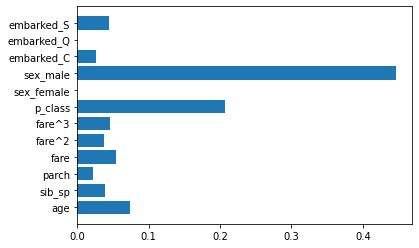

In [17]:
plt.barh(X_ts.columns, final.feature_importances_);

# End of Notebook